<a href="https://colab.research.google.com/github/dbonafilia/train_cloud_segmentation/blob/master/BasicTrainingFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First mount the Google Drive to access training data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
bucket_name = 'cloud-segmentation-dataset'
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfus!
!gcsfuse cloud-segmentation-dataset /mount

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   659  100   659    0     0  19969      0 --:--:-- --:--:-- --:--:-- 19969
OK
145 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 145 not upgraded.
Need to get 4,274 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.28.1_amd64.deb ...
Unpacking gcsfuse (0.28.1) ...
Setting up gcsfuse (0.28.1) ...


In [18]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Import necessary packages

In [0]:
from skimage import io
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split

Set up dataset file names

In [0]:
SPARCS_DATA_DIR = "/mount"
SPARCS_FILES = [os.path.join(SPARCS_DATA_DIR, f) for f in os.listdir(SPARCS_DATA_DIR)]
MASK_FILES = sorted([f for f in SPARCS_FILES if ("_mask.tif" in f and "._" not in f)])
IMAGERY_FILES = sorted([f for f in SPARCS_FILES if ("_data.tif" in f and "._" not in f)])

Load imagery and masks into memory

In [0]:
imagery = np.stack([io.imread(f) for f in IMAGERY_FILES])
masks = np.stack([io.imread(f) for f in MASK_FILES])

Split data into train, test, and validation

In [0]:
data_train, data_test, labels_train, labels_test = train_test_split(imagery, masks, test_size=0.30)
train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))
#data_validation, data_test, labels_validation, labels_test = train_test_split(data_test, labels_test, test_size=0.50)
valid_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test))

Set up Data Augmentation stuff

In [0]:
import random
IMG_HEIGHT = 256
IMG_WIDTH = 256

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 65535.0
  return input_image, tf.cast(input_mask, tf.float32)

def random_crop(input_image, input_mask):
  stacked_image = tf.concat([input_image, input_mask], 2)
  cropped_stacked_image = tf.image.random_crop(
      stacked_image, size=[IMG_HEIGHT, IMG_WIDTH, 11])
  return cropped_stacked_image[:,:,:10], cropped_stacked_image[:,:,10:]


@tf.function
def load_image_train(image, mask):
  input_image, input_mask = normalize(image, mask)
  input_mask = tf.expand_dims(input_mask,2)
  input_image, input_mask = random_crop(input_image, input_mask)
  input_image = tf.image.random_brightness(input_image, .25)
  input_image = tf.image.random_contrast(input_image, lower=.85,upper=1.15)
  if np.random.uniform() > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  if np.random.uniform() > 0.5:
    input_image = tf.image.flip_up_down(input_image)
    input_mask = tf.image.flip_up_down(input_mask)
  input_mask = tf.keras.backend.one_hot(
    tf.squeeze(tf.cast(input_mask,tf.int32)),7)
  return input_image, input_mask

def load_image_test(image, mask):
  input_image, input_mask = normalize(image, mask)
  input_mask = tf.expand_dims(input_mask,2)
  input_image, input_mask = random_crop(input_image, input_mask)
  input_mask = tf.keras.backend.one_hot(
    tf.squeeze(tf.cast(input_mask,tf.int32)),7)

  return input_image, input_mask

In [0]:
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(load_image_test)

In [0]:
dataset_iter = iter(train_dataset)

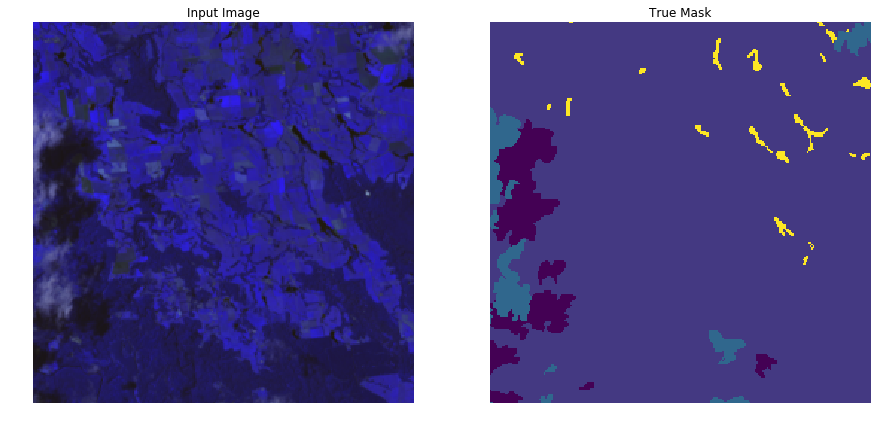

In [23]:
import sys
import matplotlib.pyplot as plt
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if display_list[i].shape[2] == 10:
      im = display_list[i][:,:,2:5]
    else:
      im = create_mask(tf.expand_dims(display_list[i], 0))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(im))
    plt.axis('off')
  plt.show()
sample_image, sample_mask = next(dataset_iter)
display([sample_image, sample_mask])

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).repeat()
dataset_iter = iter(train_dataset)

Create DICE loss function

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7))

def dice_coef_multilabel(y_true, y_pred, numLabels=7):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    
    return dice/numLabels

Create a U-Net model following Tensorflow Segmentation Example


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 10], include_top=False, weights=None)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
    upsample(32, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 10])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

/tensorflow-2.0.0-rc2/python3.6/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 10 input channels.
  str(input_shape[-1]) + ' input channels.')


In [0]:
model = unet_model(7)

In [0]:
for layer in model.layers:
  if "Model" in str(type(layer)):
    for l in layer.layers:
      if (isinstance(l,tf.keras.layers.Conv2D) or isinstance(l,tf.keras.layers.Conv2DTranspose)) or isinstance(l, tf.keras.layers.DepthwiseConv2D):
        l.add_loss(lambda: tf.keras.regularizers.l2(0.01)(l.depthwise_kernel if hasattr(l, "depthwise_kernel") else l.kernel))
  if (isinstance(layer,tf.keras.layers.Conv2D) or isinstance(layer,tf.keras.layers.Conv2DTranspose)) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
    layer.add_loss(lambda: tf.keras.regularizers.l2(0.01)(layer.depthwise_kernel if hasattr(l, "depthwise_kernel") else layer.kernel))
  if isinstance(layer, tf.keras.layers.DepthwiseConv2D):
    layer.add_loss(lambda: tf.keras.regularizers.l2(0.01)(layer.depthwise_kernel))



In [0]:
#model.load_weights("drive/My Drive/decent_starting_segmentation_model_new.ckpt")
#sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss=dice_coef_multilabel,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=7)])

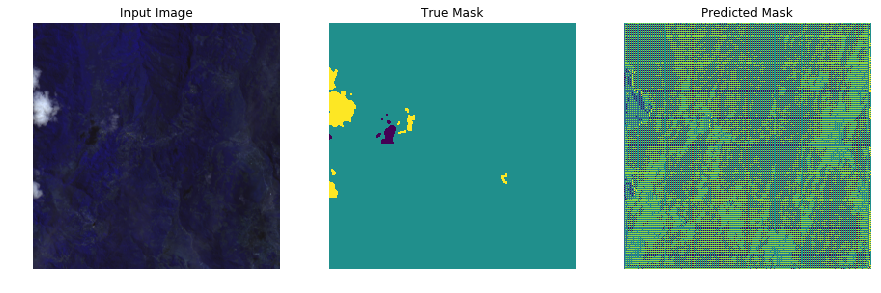

In [30]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict((image))
      im = tf.keras.backend.one_hot(
        tf.squeeze(create_mask(pred_mask)),
        7
      )
      display([image[0], mask[0], im])
show_predictions(train_dataset)

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(valid_dataset)
    show_predictions(train_dataset)   
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.iou = []
        self.val_iou = []

        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.iou.append(logs.get('mean_io_u'))
        self.val_iou.append(logs.get('val_mean_io_u'))
        self.i += 1
        plt.plot(self.x, self.loss, label="loss")
        plt.plot(self.x, self.val_loss, label="val_loss")
        plt.plot(self.x, self.iou, label="miou")
        plt.plot(self.x, self.val_iou, label="val_miou")

        plt.legend()
        plt.show();

In [0]:
valid_dataset = valid_dataset.repeat()

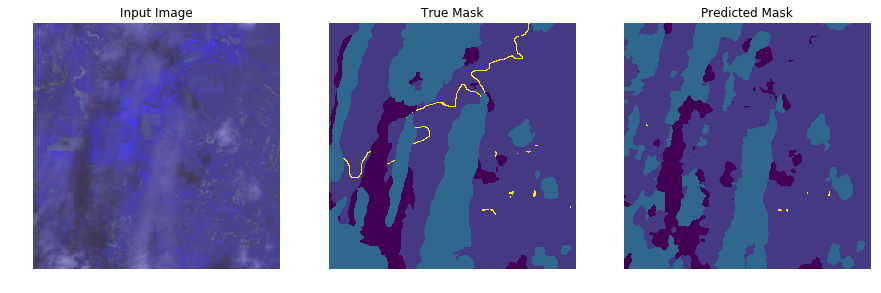

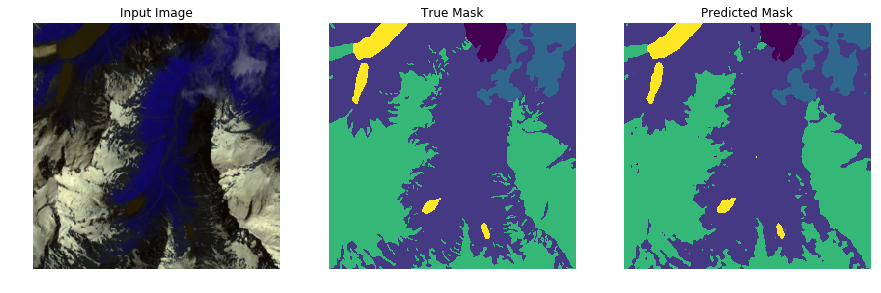


Sample Prediction after epoch 200



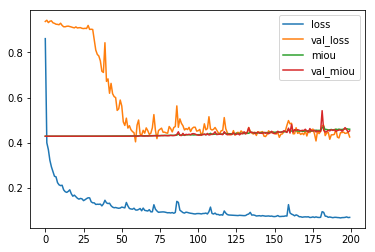

100/100 [==============================] - 207s 2s/step - loss: 0.0689 - accuracy: 0.9650 - mean_io_u: 0.4595 - val_loss: 0.4251 - val_accuracy: 0.8584 - val_mean_io_u: 0.4524
Epoch 201/500
 69/100 [===================>..........] - ETA: 56s - loss: 0.0690 - accuracy: 0.9651 - mean_io_u: 0.4645

In [0]:
from IPython.display import clear_output

EPOCHS = 500
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=100,
                          validation_steps=10,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), MetricsCallback()])